In [13]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime as dt
from datetime import datetime
from dateutil import tz

#import h5py
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # may not use

from skimage.util import montage
from matplotlib import ticker  # New import for handling tick locations
from matplotlib import colors as mcolors
import matplotlib.patches as patches

# folder to save plots to 
plots_folder_path = '../figures/charts'

### Notes 

In [14]:
# Main settings
npy_snapshot_file = 'TB_scene_60_jan19_mar23_v2.npy' # pre-processed snapshot file

#Specify pre-trained model
trained_model_file = 'scene_180_jan19_mar23_bin_128D.keras'

# Load anomaly data
anomaly_test = np.load('anomaly_test.npy', allow_pickle = True)

# Training options - keep data manipulatins for re-scaling etc later
# remove snapshots with no tranmissions from training data
# generally set to 'no': there may well be blank snapshots
remove_blank_snapshots = 'yes'

# use binary counts (transforms all data to binary counts)
# NB this simplifies problem. Shows only where vessels have been.
binary_counts = 'no'

### Analysis filter options
# This is used to remove what is used in analysis of results
# If remove_stationary_vessels set to 'yes', then stationary trajectories are removed 
remove_stationary_vessels = 'no'

In [15]:
# load pre-processed data

AIS_snapshots = np.load(npy_snapshot_file, allow_pickle = True)
num_cells_x, num_cells_y = AIS_snapshots[0].shape # get snapshot dimensions
# If labels required use code below
#AIS_snapshot_label = np.load('AIS_snapshot_label_10min.npy', allow_pickle = True)


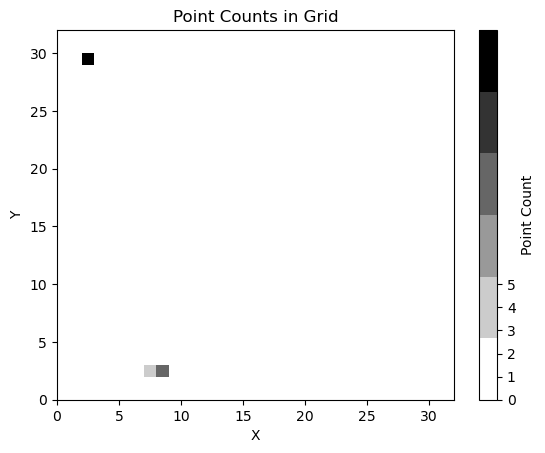

In [16]:
# Sanity check data

# Function to visualise processed data

ymax, xmax = pd.DataFrame(AIS_snapshots[0]).shape # rows, cols
    
def plot_grid(grid_df, xmin, xmax, ymin, ymax):
    '''Function to take arbitrary sized dataframe of spatial coordinates and plot'''
    # Calculate the number of intervals for the integer scale
    x_intervals = grid_df.shape[1]
    y_intervals = grid_df.shape[0]

    # Create arrays of integer coordinates for the cells
    x_coords = np.arange(xmin, xmax + 1, (xmax - xmin) // x_intervals)
    y_coords = np.arange(ymin, ymax + 1, (ymax - ymin) // y_intervals)

    # Determine the number of unique levels in the data
    num_levels = len(np.unique(grid_df.values))

    # Create a discrete colormap with the number of levels
    cmap = plt.cm.get_cmap('gray', num_levels)
    cmap = cmap.reversed()  # Invert the colormap

    # Plot the cell counts as a heatmap using the inverted discrete colormap
    plt.pcolormesh(x_coords, y_coords, grid_df.values, cmap=cmap, shading='auto')
    plt.colorbar(ticks=np.arange(num_levels), label='Point Count')  # Add discrete colorbar with label

    # Set axis labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Point Counts in Grid')

    

# for i in range(0,5):
#     plot_grid(pd.DataFrame(AIS_snapshots[i]), 0, xmax, 0, ymax)


# Call the function to generate the plot
plot_grid(pd.DataFrame(AIS_snapshots[10]), 0, xmax, 0, ymax)

# # Output to pdf
# file_name = 'gridcountexample_traj.pdf'
# file_path = os.path.join(plots_folder_path, file_name)

# # Save the plot to a file
# plt.savefig(file_path, format='pdf')
# # Show the plot
plt.show()

In [17]:
# flatten grids for filtering
AIS_snapshots_2d = AIS_snapshots.reshape(AIS_snapshots.shape[0], -1)

# put nparray back to df
train = pd.DataFrame(AIS_snapshots_2d)

# drops rows with nans
train = train.dropna()


In [18]:
### Filter *Training Data* - these are set in config section

# get rid of all zero examples and nans
# this will remove 'real' situations where there are no tranmissions
if remove_blank_snapshots == 'yes':
    train = train.loc[~(train == 0).all(axis=1)]


# apply ceiling to reduce stationary hotspots
# this will remove counts so snapshot is binary
if binary_counts == 'yes':
    train = np.clip(train, 0, 1)

In [19]:
# Scale the training data

# Transform the data to log scale
train = np.log(1. + train).values

# Create Scaler instance to fix between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data
scaler.fit(train)

# Transform the data
train = scaler.transform(train)

# back to df
train = pd.DataFrame(train)

# Reshape image in 3 dimensions (height = 32px, width = 32px , chanel = 1)
train = train.values.reshape(-1,num_cells_x,num_cells_y,1)

print('Training Images', train.shape)

Training Images (36212, 32, 32, 1)


In [20]:
# Make a train, val, and test set. NB default is to shuffle data
X_train, X_test = train_test_split(train, test_size=0.4, random_state=42)
X_val, X_test = train_test_split(X_test, test_size=0.5, random_state=42)
print('Training Images', X_train.shape,'Validation Images', X_val.shape, 'Testing Images', X_test.shape)

Training Images (21727, 32, 32, 1) Validation Images (7242, 32, 32, 1) Testing Images (7243, 32, 32, 1)


In [21]:
# Paramters for VAE - this is not optimised!
batch_size = 256
original_shape = train.shape[1:]
original_dim = np.prod(original_shape)
latent_dim = 128 # 64 seems to be enough
large_dim = 512
intermediate_dim = 256
final_dim = 128
epochs = 500 # let early stopping conclude training 
epsilon_std = 1.0 

In [22]:
# Encoder layers
in_layer = Input(shape=original_shape)
x = Flatten()(in_layer)
h = Dense(large_dim, activation='relu')(x)
h = Dense(intermediate_dim, activation='relu')(h)
h = Dense(final_dim, activation = 'relu')(h)

# Latent space
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Latent space sampler
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder layers
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_i = Dense(large_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

# Decoder model
f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
i_decoded = decoder_i(h_decoded)
x_decoded_mean = decoder_mean(i_decoded)
x_decoded_snapshot = Reshape(original_shape)(x_decoded_mean)



In [23]:
# instantiate VAE model
vae = Model(in_layer, x_decoded_snapshot)

# Compute VAE loss
cross_ent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(cross_ent_loss + kl_loss)

# Construct model
vae.add_loss(vae_loss)

# set optimiser
vae.compile(optimizer='adam')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# show model (uncomment)
#vae.summary()

In [24]:
# Load trained model 
vae = keras.models.load_model(trained_model_file)

Build a model to project inputs on the latent space

In [25]:
### Analysis settings

### Idea is that we can detect certain type of anomaly by filering know ones
### e.g. super low errors are anomalous in that they tend to be stationary vessels with 1 or 2 counts...
### ... at least in the case of vessel specific trajectories in 30 min window

# set analysis data set
analysis_data = X_test

# set number of examples from best/worst/median scores
n_examples = 50

# normalise error by number of non-zero cells in snapshot
# (majority of cells in an image have zero counts so skew niave scorer)
normalise_errors = 'yes'

# set the number of cells that constitutes a stationary vessel

n_stat_cells = 5
    
if remove_stationary_vessels == 'yes':
    mask = np.count_nonzero(analysis_data, axis=(1, 2)) > n_stat_cells

    # Remove the elements with only one non-zero element
    analysis_data = analysis_data[mask[:,0]]

17/85 [=====>........................] - ETA: 0s 

2023-08-27 09:34:08.587058: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-27 09:34:08.641118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 4ms/step


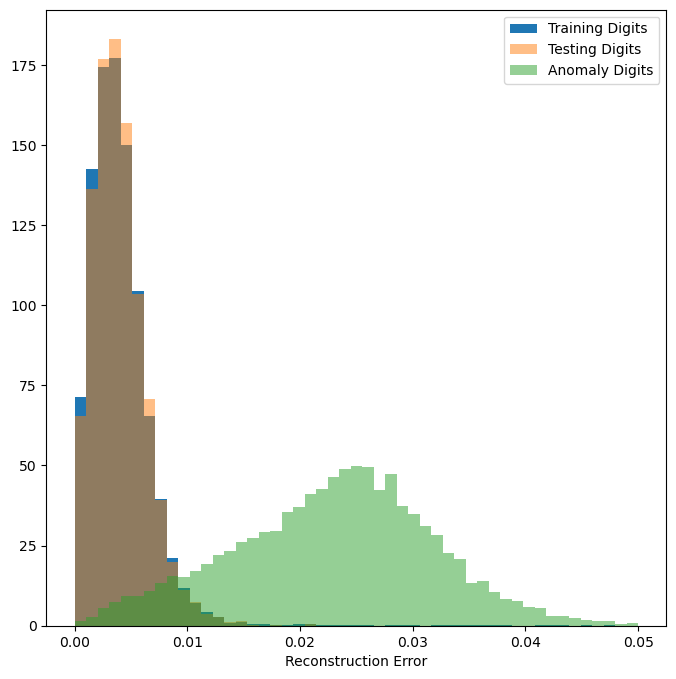

In [26]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), (1,2,3))

max_err = 0.05

fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(X_train), bins = np.linspace(0, max_err, 50), 
         label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(X_test), bins = np.linspace(0, max_err, 50), 
         label = 'Testing Digits', density = True, alpha = 0.5)
ax1.hist(model_mse(anomaly_test), bins = np.linspace(0, max_err, 50), 
         label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

40/40 [==============================] - 0s 3ms/step


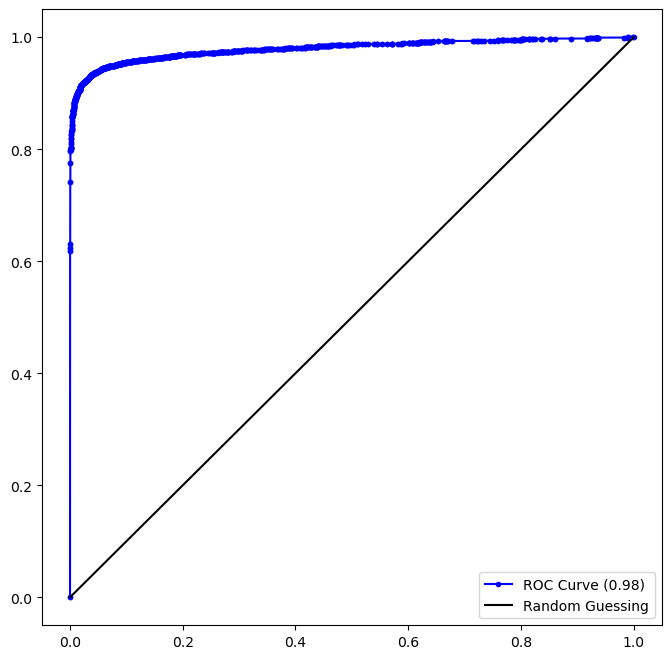

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
mse_score = np.concatenate([model_mse(X_test), model_mse(anomaly_test)],0)
true_label = [0]*X_test.shape[0]+[1]*anomaly_test.shape[0]
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

In [31]:
# Analysis: calculate errors on analysis set
# set percentage of analysis set to test

test_pct = 0.6 # NB 0.05 finds some nice errors
errors = []
error_index = []
best_index = []
med_index = []

for i in range(0,int(analysis_data.shape[0]*test_pct)):
    x = analysis_data[i]
    if normalise_errors == 'yes':
        # count non-zero cells
        nz_count = np.count_nonzero(x)
        # MAE
        re = np.mean(np.sqrt(np.square(x-vae.predict(x, batch_size=256, verbose = 0))))
        # MAE adjusted for number of non-zero cells
        errors.append(re/nz_count)
    else:
        # MAE of errors in all cells per snapshot
        re = re = np.mean(np.sqrt(np.square(x-vae.predict(x, verbose = 0))))
        errors.append(re)
      

In [32]:
# Analysis: find examples of best, worst and typical reconstriction losses
n_examples = 4
# get indices of sorted errors
sorted_errors = np.argsort(errors)
# highest errors
error_index = sorted_errors[-n_examples:]
worst_rec_errs =  analysis_data[error_index]
# lowest errors
best_index = sorted_errors[:n_examples]
best_rec_errs =  analysis_data[best_index]
# median errors
middle_start = len(errors) // 2 - n_examples // 2
med_index = sorted_errors[middle_start:middle_start+n_examples]
med_rec_errs =  analysis_data[med_index]

### Compare Inputs with reconstructions

******** Worst Reconstruction Errors *********


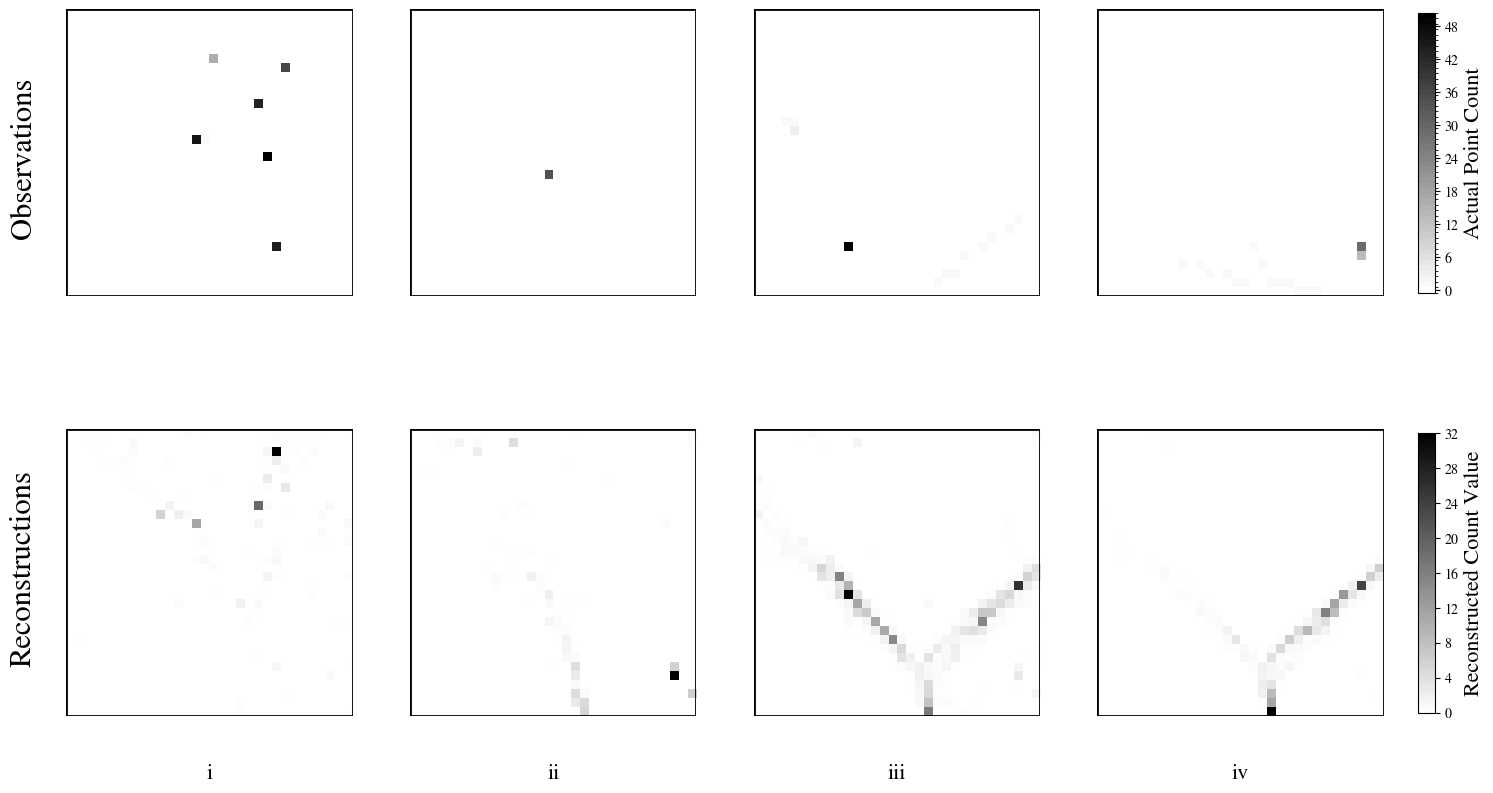

******** Median Reconstruction Errors *********


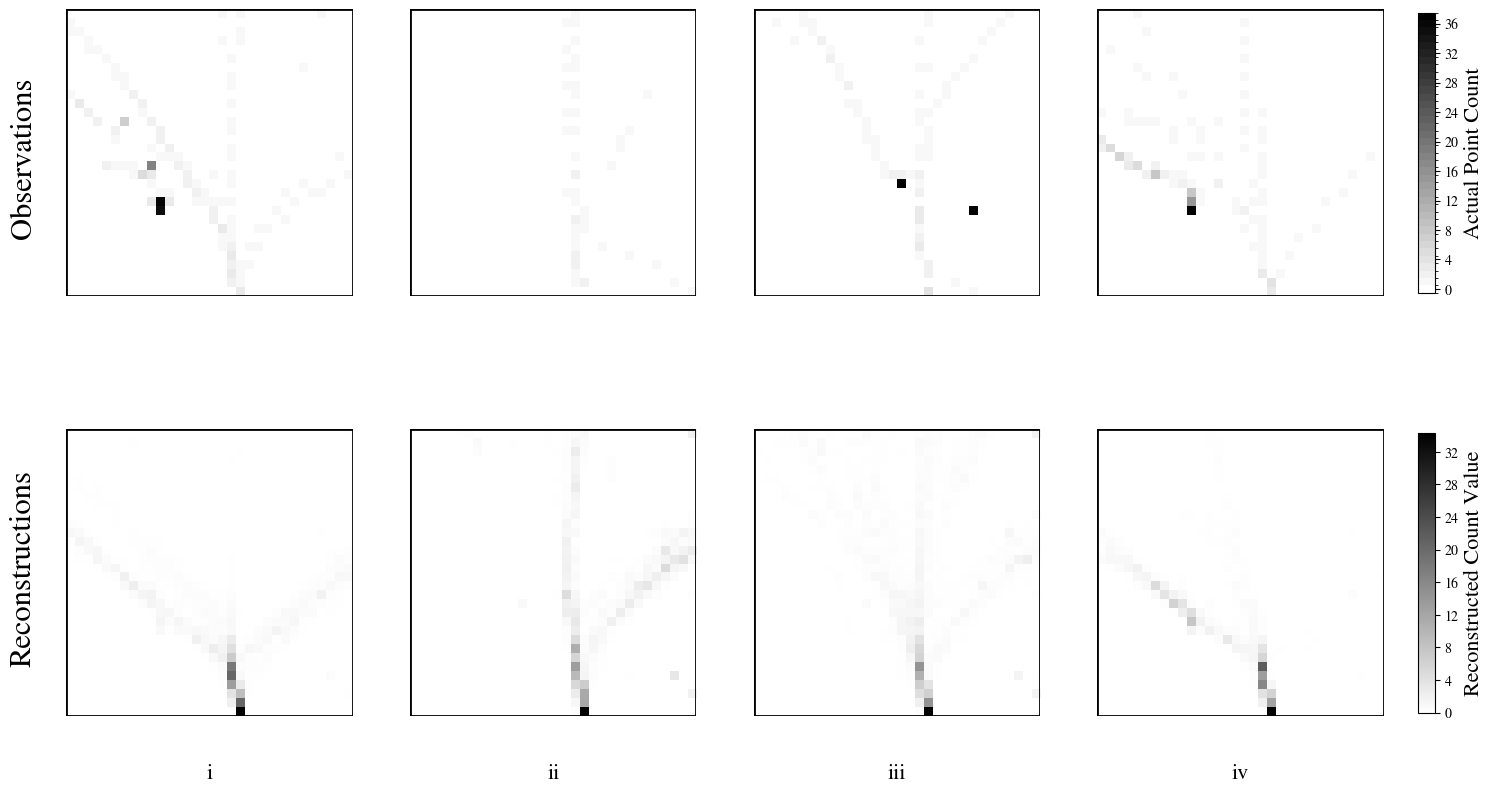

In [33]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

def compare_input_recon(data, n_examples):
    fig, m_axs = plt.subplots(2, n_examples, figsize=(17, 10))
    
    for ax in m_axs.ravel():
        ax.axis('off')
    # set height of labels with second number
    fig.text(0.1, 0.7, 'Observations', ha='center', va='center', size=22, rotation='vertical')
    fig.text(0.1, 0.29, 'Reconstructions', ha='center', va='center', size=22, rotation='vertical')
    
    # Roman numerals
    roman_numerals = ['i', 'ii', 'iii', 'iv']
    for i, ax in enumerate(m_axs[1]):
        ax.text(0.5, -0.2, roman_numerals[i], ha='center', va='center', transform=ax.transAxes, fontsize=16)
    
    # Expected shape based on the scaler
    expected_shape = (data[0].size // scaler.scale_.size, scaler.scale_.size)
    
    for i in range(n_examples):
        # Reshape the data to expected shape
        data_2d = data[i].reshape(expected_shape)
        
        # Inverse transform the 2D data
        original_data_2d = scaler.inverse_transform(data_2d)
        
        # Reshape back to 3D and apply the exponential function
        original_data = (np.exp(original_data_2d) - 1.).reshape(data[i].shape)
        
        # Inverse transform the reconstructed data
        recon_data_2d = vae.predict(data[i:i+1], verbose=0)[0].reshape(expected_shape)
        recon_original_2d = scaler.inverse_transform(recon_data_2d)
        recon_data = (np.exp(recon_original_2d) - 1.).reshape(data[i].shape)
        
        # Determine the global maximum value based on the maximum of both original and reconstructed data
        if i == 0:  # Only do this on the first iteration
            max_value = int(np.max([original_data, recon_data]))
            bounds = np.arange(0, max_value + 2) - 0.5
            cmap_obs = plt.cm.get_cmap('gray_r', max_value + 1)
            norm_obs = mcolors.BoundaryNorm(bounds, cmap_obs.N)
        
        # Display original images with discrete colormap
        im_in = m_axs[0, i].imshow(original_data[:, :, 0], cmap=cmap_obs, norm=norm_obs)
        border_in = patches.Rectangle((0, 0), 1, 1, transform=m_axs[0, i].transAxes, 
                                      color='black', linewidth=2, fill=False)
        m_axs[0, i].add_patch(border_in)
        
        # Display reconstructed images with continuous colormap
        im_vae = m_axs[1, i].imshow(recon_data[:, :, 0], cmap='gray_r')
        border_vae = patches.Rectangle((0, 0), 1, 1, transform=m_axs[1, i].transAxes, 
                                       color='black', linewidth=2, fill=False)
        m_axs[1, i].add_patch(border_vae)

    # Add a colorbar for observations
    cbar_ax_obs = fig.add_axes([0.92, 0.565, 0.01, 0.28]) #adj 2nd number for bottom, last numer for height
    cbar_obs = fig.colorbar(im_in, cax=cbar_ax_obs, ticks=np.arange(0, max_value + 1), spacing='proportional')
    cbar_obs.locator = ticker.MaxNLocator(integer=True)  # Ensure only integers are used
    cbar_obs.update_ticks()
    cbar_obs.set_label('Actual Point Count', fontsize = 16)
    
    # Add a colorbar for reconstructions
    cbar_ax_rec = fig.add_axes([0.92, 0.145, 0.01, 0.28])
    cbar_rec = fig.colorbar(im_vae, cax=cbar_ax_rec)
    cbar_rec.locator = ticker.MaxNLocator(integer=True)  # Ensure only integers are used
    cbar_rec.update_ticks()
    cbar_rec.set_label('Reconstructed Count Value', fontsize = 16)


    
#     The values [0.92, 0.70, 0.01, 0.15] and [0.92, 0.25, 0.01, 0.15] represent the 
#     adjusted positions for the colorbars. You might need to further fine-tune these values 
#     for exact alignment depending on your data and the exact appearance of the plots on your system.

print("******** Worst Reconstruction Errors *********")
compare_input_recon(worst_rec_errs,n_examples)
# #output to pdf
file_name = 'Vis_compare_scene_cont_worst_recons.pdf'
file_path = os.path.join(plots_folder_path, file_name)
#plt.savefig(file_path)
plt.show()

print("******** Median Reconstruction Errors *********")
compare_input_recon(med_rec_errs,n_examples)
# #output to pdf
file_name = 'Vis_compare_scene_cont_median_recons.pdf'
file_path = os.path.join(plots_folder_path, file_name)
#plt.savefig(file_path)
plt.show()